In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import os

# 📁 CONFIGURAZIONI
MODEL_PATH = "/content/drive/MyDrive/NeuroOnco/Modello/cnn_model_with_series.pt"
PAZIENTE_PT = "/content/drive/MyDrive/NeuroOnco/Derivate/CORZANI1.pt"  # 🔁 Modifica con il file corretto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class CNN3D(torch.nn.Module):
    def __init__(self, in_channels, n_classes=2):
        super().__init__()
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels, 32, 3, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Dropout3d(0.2),
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv3d(32, 64, 3, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Dropout3d(0.3),
        )
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 128, 3, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool3d(1),
        )
        self.fc = torch.nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Carica checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
selected_series = checkpoint["selected_series"]
model = CNN3D(in_channels=len(selected_series))

if torch.cuda.device_count() > 1:
    print(f"🧠 Usando {torch.cuda.device_count()} GPU con DataParallel")
    model = torch.nn.DataParallel(model)

model = model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ Modello caricato.")


✅ Modello caricato.


In [3]:
PATCH_SIZE = checkpoint.get("patch_size", (15, 15, 15))  # fallback se mancante
THRESHOLD = 0.98  # soglia CNN per accettare voxel nel growing


In [4]:
pt = torch.load(PAZIENTE_PT)
volume_all = pt["volume"].float()
serie_names = pt["nomi_serie"]
roi_masks = pt["roi_masks"]
serie_names_lower = [s.lower() for s in serie_names]
selected_indices = [serie_names_lower.index(s.lower()) for s in selected_series]
volume = volume_all[selected_indices].contiguous()  # 🔁 Mantieni volume su CPU


roi_malato = roi_masks["MALATO"].clone().detach().to(torch.bool)


print(f"📐 Volume: {volume.shape}, Voxels iniziali nella ROI MALATO: {roi_malato.sum().item()}")


📐 Volume: torch.Size([6, 340, 560, 560]), Voxels iniziali nella ROI MALATO: 258385


In [5]:
def estrai_patch(volume, coord, patch_size=(15, 15, 15)):
    c, z, y, x = volume.shape[0], *coord
    pz, py, px = patch_size
    hz, hy, hx = pz//2, py//2, px//2

    z0, z1 = z - hz, z + hz + 1
    y0, y1 = y - hy, y + hy + 1
    x0, x1 = x - hx, x + hx + 1

    if z0 < 0 or y0 < 0 or x0 < 0 or z1 > volume.shape[1] or y1 > volume.shape[2] or x1 > volume.shape[3]:
        return None
    return volume[:, z0:z1, y0:y1, x0:x1]

def get_border_voxels(mask):
    from scipy.ndimage import binary_dilation
    dilated = binary_dilation(mask.cpu().numpy())
    border = dilated & ~mask.cpu().numpy()
    coords = list(zip(*np.where(border)))
    return coords


In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt



import time



log_x = []
log_bordo = []
log_validi = []
log_testati = []
log_accettati = []
log_scartati = []

def mostra_andamento_accrescimento(x, bordo, validi, testati, accettati, scartati):
    import matplotlib.pyplot as plt
    clear_output(wait=True)  # Cancella il grafico precedente
    plt.figure(figsize=(10, 6))
    plt.clf()  # cancella il grafico precedente
    plt.plot(x, bordo, label="Voxel bordo totali")
    plt.plot(x, validi, label="Voxel validi (patch ok)")
    plt.plot(x, testati, label="Voxel testati CNN")
    plt.plot(x, accettati, label="Accettati")
    plt.plot(x, scartati, label="Scartati")
    plt.xlabel("Iterazione")
    plt.ylabel("Numero voxel")
    plt.title("Andamento dell'accrescimento")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



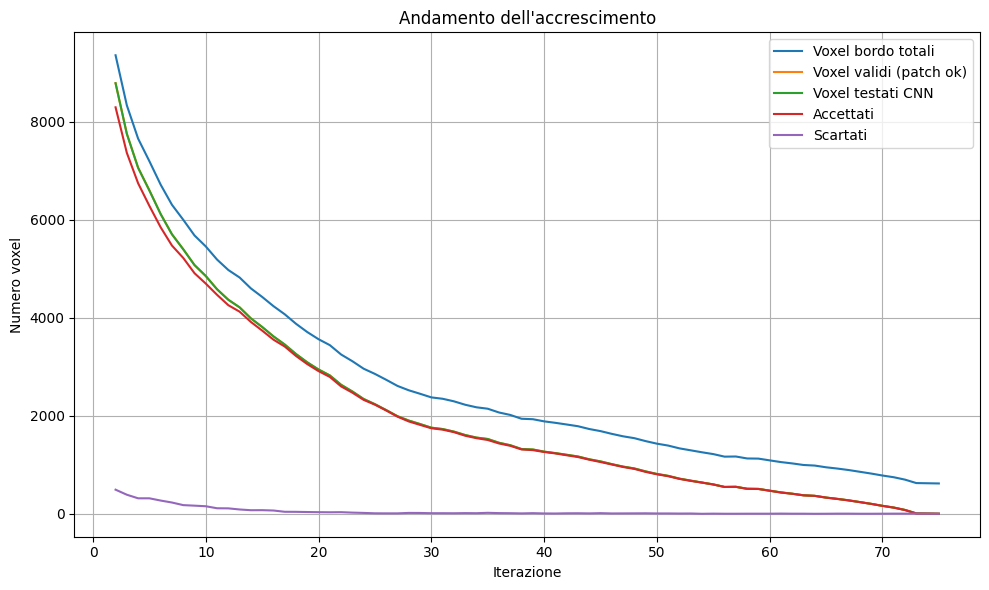

⚠️ Crescita bassa: 0. Tentativo 3/5
🧱 Iterazione 76: voxel di bordo da testare: 618
⚠️ Nessuna patch valida.


NameError: name 'roi_seed' is not defined

In [7]:
from scipy.ndimage import binary_dilation, convolve
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 📌 Parametri
max_voxels = 500000
min_neighbors = 3
max_attempts = 5
growth_threshold = 10
plot_freq_iterazioni = 1

# 🧠 Stato iniziale
grown = roi_malato.clone()
tested = set()
added = 0
tentativi = 0
iterazione = 0

# 📊 Per il grafico
log_x, log_acc_iter, log_scart_iter = [], [], []



print("🚀 Inizio accrescimento...")

# 📌 Parametri GPU
kernel = torch.ones((1, 1, 3, 3, 3), device=device)
hz, hy, hx = [p // 2 for p in PATCH_SIZE]
min_neighbors = 12
max_voxels = 500000
growth_threshold = 10
max_attempts = 5
batch_size = 4096

# Stato iniziale
volume = volume.to(device)
grown = roi_malato.clone().to(device)
tested = torch.zeros_like(grown, dtype=torch.bool)
added = 0
tentativi = 0
iterazione = 0
log_x, log_acc_iter, log_scart_iter = [], [], []

print("🚀 Inizio accrescimento...")

while added < max_voxels:
    iterazione += 1

    # 1. Calcolo voxel di bordo con convoluzione
    grown_u8 = grown.unsqueeze(0).unsqueeze(0).float()  # (1,1,Z,Y,X)
    neighbor_map = F.conv3d(grown_u8, kernel, padding=1)
    border = (neighbor_map >= min_neighbors) & (~grown_u8.bool())

    # Rimuove voxel già testati
    border_mask = border.squeeze(0).squeeze(0) & (~tested)

    coords = torch.nonzero(border_mask, as_tuple=False)  # (N, 3)
    n_bordo = coords.shape[0]
    if n_bordo == 0:
        print("✅ Nessun voxel di bordo valido.")
        break

    print(f"🧱 Iterazione {iterazione}: voxel di bordo da testare: {n_bordo}")

    # 2. Estrai patch per ogni coord
    patches = []
    valid_coords = []
    for v in coords:
        z, y, x = v
        if z - hz < 0 or z + hz + 1 > volume.shape[1]: continue
        if y - hy < 0 or y + hy + 1 > volume.shape[2]: continue
        if x - hx < 0 or x + hx + 1 > volume.shape[3]: continue
        patch = volume[:, z-hz:z+hz+1, y-hy:y+hy+1, x-hx:x+hx+1]
        if torch.isnan(patch).any() or torch.isinf(patch).any():
            continue
        patches.append(patch)
        valid_coords.append((z.item(), y.item(), x.item()))
        tested[z, y, x] = True

    n_validi = len(patches)
    if not patches:
        print("⚠️ Nessuna patch valida.")
        break

    patches_tensor = torch.stack(patches)  # (N, C, Z, Y, X)

    # 3. Inference CNN
    with torch.no_grad():
        probs = []
        for i in range(0, len(patches_tensor), batch_size):
            batch = patches_tensor[i:i+batch_size].to(device)
            logits = model(batch)
            prob = F.softmax(logits, dim=1)[:, 1]
            probs.append(prob)
        probs = torch.cat(probs)

    # 4. Aggiornamento ROI
    accettati = 0
    scartati = 0
    scartati_per_prob = 0
    scartati_per_vicini = 0

    for i, p in enumerate(probs):
        z, y, x = valid_coords[i]
        vicini = neighbor_map[0, 0, z, y, x].item()

        if p.item() < THRESHOLD:
            scartati += 1
            scartati_per_prob += 1
        elif not (3 <= vicini <= 24):
            scartati += 1
            scartati_per_vicini += 1
        else:
            grown[z, y, x] = True
            accettati += 1
            added += 1
            if added >= max_voxels:
                break

    print(f"🔁 Iterazione {iterazione}: accettati {accettati}, scartati {scartati} "
          f"(prob: {scartati_per_prob}, vicini: {scartati_per_vicini}), totale accresciuti: {added}")


    # LOG per grafico
    if iterazione > 1:
        log_x.append(iterazione)
        log_bordo.append(coords.shape[0])
        log_validi.append(len(patches))
        log_testati.append(len(probs))
        log_accettati.append(accettati)
        log_scartati.append(scartati)

        mostra_andamento_accrescimento(log_x, log_bordo, log_validi, log_testati, log_accettati, log_scartati)

    if accettati < growth_threshold:
        tentativi += 1
        print(f"⚠️ Crescita bassa: {accettati}. Tentativo {tentativi}/{max_attempts}")
        if tentativi >= max_attempts:
            print("⛔ Fermo: crescita stagnante.")
            break
    else:
        tentativi = 0

roi_accresciuta = grown & (~roi_seed)

In [8]:
pt["roi_masks"]["M_GROWN"] = grown.cpu().numpy()
output_path = PAZIENTE_PT.replace(".pt", "_with_growth.pt")
torch.save(roi_accresciuta.cpu(), output_path)

print(f"✅ ROI accresciuta salvata come 'M_GROWN' in:\n{output_path}")

NameError: name 'roi_accresciuta' is not defined